# Using s3fs
I treid with this and it was not as easy as Herbie. I may need to understand S3 objects and their hirarachie better. Check that the output is not having TMP variable.

## Using s3fs
# Exploring the use of `s3fs` for accessing data stored in S3 buckets. Access and check the a variable in a dataset.


In [4]:
import s3fs
import xarray as xr

# Define the path
bucket = "hrrrzarr"
level_type = 'sfc'  # Options: 'prs', 'grid', 'sfc'
date = "20200810"
time = "12z"
run_type = "anl"  # Options: 'fcst', 'anl'
level = "surface"
var_name = "TMP"


In [ ]:
# path to the data
path = f"{bucket}/{level_type}/{date}/{date}_{time}_{run_type}.zarr/{level}/{var_name}"
print(path)

fs = s3fs.S3FileSystem(anon=True) 

print(fs.glob(f"{path}*"))

store = s3fs.S3Map(root=path, s3=fs)
ds = xr.open_zarr(store=store, consolidated=True)

In [5]:
ds.variables

Frozen({'forecast_period': <xarray.Variable ()> Size: 8B
[1 values with dtype=timedelta64[ns]]
Attributes:
    standard_name:  forecast_period, 'forecast_reference_time': <xarray.Variable ()> Size: 8B
[1 values with dtype=datetime64[ns]]
Attributes:
    standard_name:  forecast_reference_time, 'height': <xarray.Variable ()> Size: 8B
[1 values with dtype=float64]
Attributes:
    long_name:  height
    units:      m, 'pressure': <xarray.Variable ()> Size: 8B
[1 values with dtype=float64]
Attributes:
    long_name:  pressure
    units:      Pa, 'projection_x_coordinate': <xarray.IndexVariable 'projection_x_coordinate' (projection_x_coordinate: 1799)> Size: 14kB
array([-2697520.142522, -2694520.142522, -2691520.142522, ...,  2690479.857478,
        2693479.857478,  2696479.857478])
Attributes:
    standard_name:  projection_x_coordinate
    units:          m, 'projection_y_coordinate': <xarray.IndexVariable 'projection_y_coordinate' (projection_y_coordinate: 1059)> Size: 8kB
array([-158730

# Now Herbie 

It simplifies accessing data with `xarray`.

In [1]:
from herbie import Herbie
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


#### Create a Herbie object for the HRRR model, specifying the product and forecast hour


In [ ]:
H = Herbie('2020-08-10 12:00', model='hrrr', product='sfc', fxx=6)
print("Grib file path:", H.grib)


# 10 m U and V wind components.

Check the inventory for variables and download, it will save it in your locale directory


In [3]:
inventory = H.inventory("(?:U|V)GRD:10 m")
print(inventory)

# Download
H.download("(?:U|V)GRD:10 m")

# xarray dataset
ds = H.xarray("(?:U|V)GRD:10 m")


    grib_message  start_byte    end_byte              range  \
70            71    47029473  48183467.0  47029473-48183467   
71            72    48183468  49274222.0  48183468-49274222   

        reference_time          valid_time variable              level  \
70 2020-08-10 12:00:00 2020-08-10 18:00:00     UGRD  10 m above ground   
71 2020-08-10 12:00:00 2020-08-10 18:00:00     VGRD  10 m above ground   

   forecast_time                          search_this  
70   6 hour fcst  :UGRD:10 m above ground:6 hour fcst  
71   6 hour fcst  :VGRD:10 m above ground:6 hour fcst  


/Users/bhupendra/anaconda3/envs/trial/lib/python3.12/site-packages/herbie/core.py:1096: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")



# Plotting Wind Data
# Visualizing wind vectors and wind speed over the U.S. Midwest region.


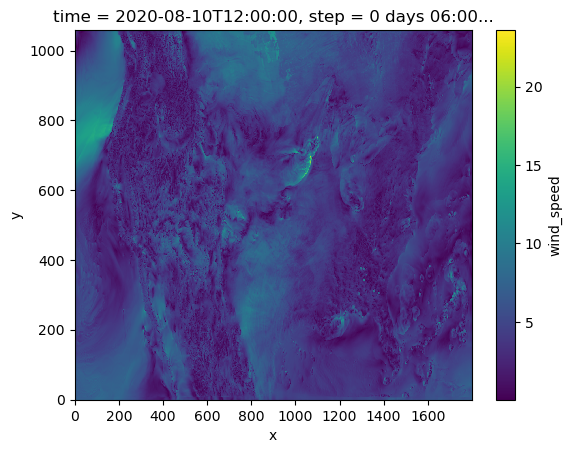

In [8]:
# Calculate wind speed
ds['wind_speed'] = np.sqrt(ds['u10']**2 + ds['v10']**2)
ds.wind_speed.plot()

I will plot it using MPL for better controll

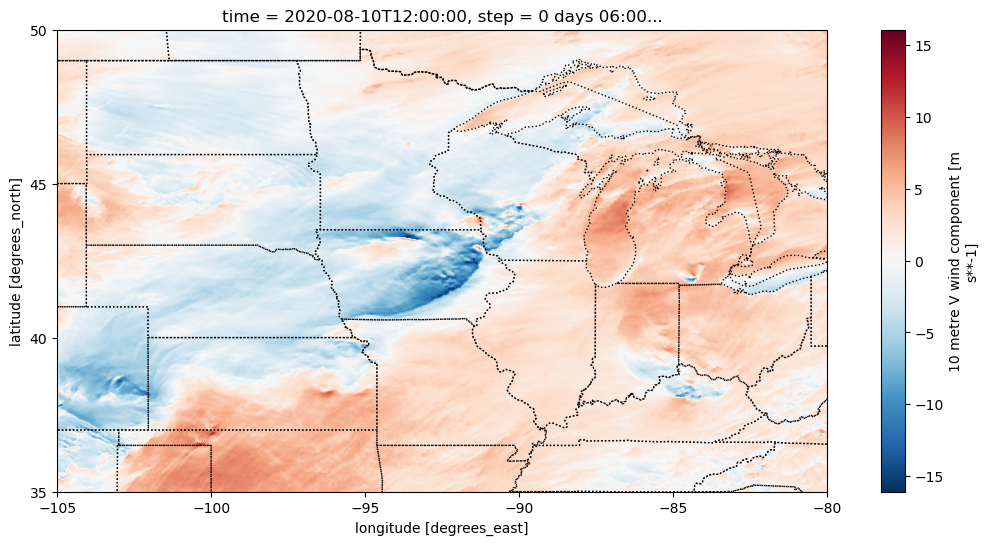

In [10]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, -105, 35, 50], crs=ccrs.PlateCarree())
# Map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Set tickmarks
ax.set_xticks(np.arange(-105, -79, 5))
ax.set_yticks(np.arange(35, 51, 5))

ds.v10.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=True)
#ds.u10.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=True)
ax.coastlines()

We will see better features in speed, so lets create a plot of wind speed using contour fill


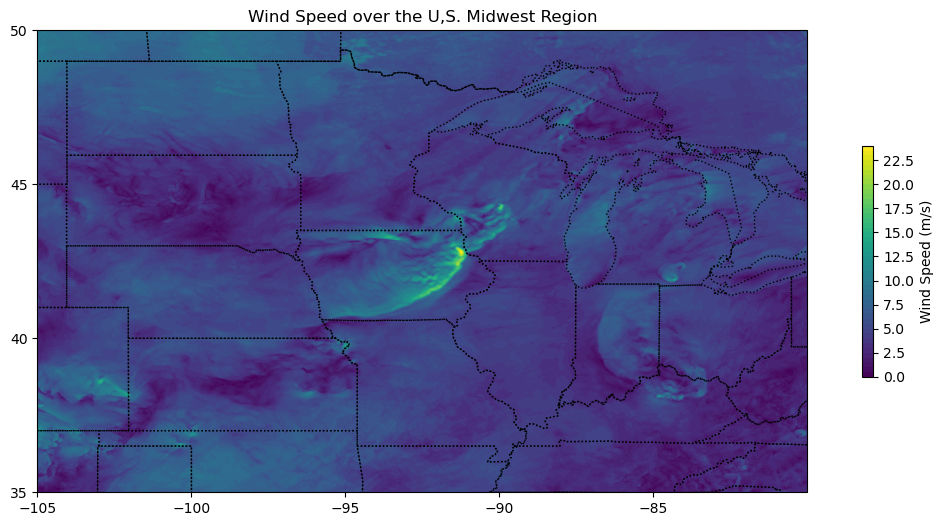

In [17]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-105, -80, 35, 50], crs=ccrs.PlateCarree()) 

# Map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Set tickmarks
ax.set_xticks(np.arange(-105, -80, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(35, 51, 5), crs=ccrs.PlateCarree())

# Plot wind speed as contours
contour_fill = ax.contourf(ds['longitude'], ds['latitude'], wind_speed, levels=50,
                           transform=ccrs.PlateCarree(), cmap='viridis')

plt.colorbar(contour_fill, ax=ax, shrink=0.5, label='Wind Speed (m/s)')


ax.coastlines()
plt.title('Wind Speed over the U,S. Midwest Region')
plt.show()


Now we will add contours 

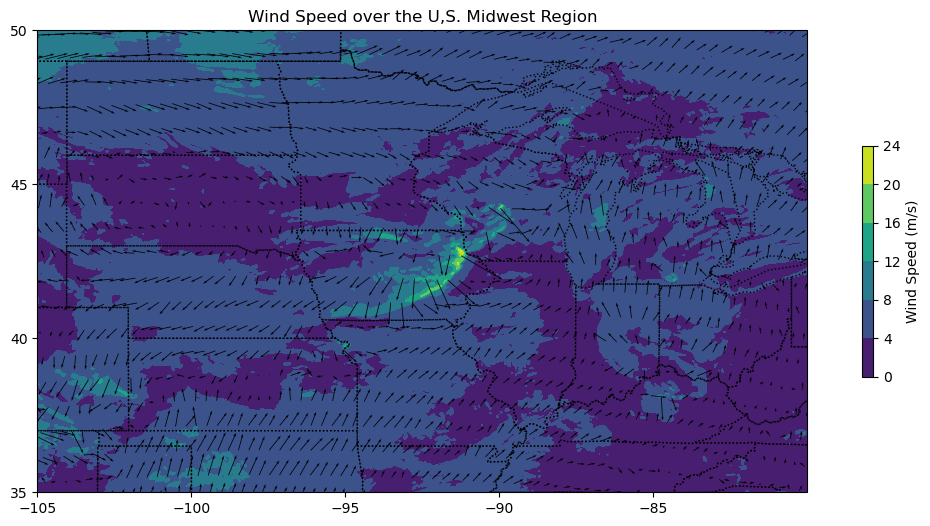

In [18]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-105, -80, 35, 50], crs=ccrs.PlateCarree())  
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

ax.set_xticks(np.arange(-105, -80, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(35, 51, 5), crs=ccrs.PlateCarree())

# Plot contours
contour_fill = ax.contourf(ds['longitude'], ds['latitude'], wind_speed, levels=6,
                           transform=ccrs.PlateCarree(), cmap='viridis')

plt.colorbar(contour_fill, ax=ax, shrink=0.5, label='Wind Speed (m/s)')

# Overlay wind
skip = (slice(None, None, 30), slice(None, None, 10))  #  skip this could be better
Q = ax.quiver(ds['longitude'][skip], ds['latitude'][skip], ds['u10'][skip], ds['v10'][skip], color='black',
              scale=300, width=0.001, transform=ccrs.PlateCarree())

ax.coastlines()
plt.title('Wind Speed over the U,S. Midwest Region')
plt.show()